In [1]:
import pandas as pd

In [2]:
players = pd.read_json("../data/jsons/players_data.json")
players.head()

,player,player_name,assists,bonus,bps,clean_sheets,creativity,element,expected_assists,expected_goal_involvements,...,loaned_in,loaned_out,offside,open_play_crosses,penalties_conceded,recoveries,tackled,tackles,target_missed,winning_goals
0,0,A.Armstrong,0,0,25,0,0.0,408,0.0,0.12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,A.Armstrong,0,0,0,0,0.0,408,0.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,A.Armstrong,0,0,3,0,1.2,408,0.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,A.Armstrong,0,0,8,0,10.3,408,0.0,0.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,A.Armstrong,0,0,2,0,0.0,408,0.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
seasons = pd.read_json("../data/jsons/seasons_data.json")
seasons.head()

,season,assists,bonus,bps,chance_of_playing_next_round,chance_of_playing_this_round,clean_sheets,code,cost_change_event,cost_change_event_fall,...,now_cost_rank,now_cost_rank_type,points_per_game_rank,points_per_game_rank_type,saves_per_90,selected_rank,selected_rank_type,starts,starts_per_90,points_per_90
0,2016-17,0,0,18,100,100,0,48844,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-17,0,2,660,100,100,12,11334,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-17,1,19,723,0,75,10,51507,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-17,0,0,5,100,100,0,17127,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-17,0,2,296,75,100,5,158074,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### **Merge Data**

In [4]:
seasons = seasons[["code", "season", "id", "element_type", "position", "first_name", "second_name", "web_name", "team_code", "team_name", "now_cost", "cost_change_start"]]

In [5]:
# create a season column 

format_season = lambda begin_year: f"{begin_year}-{begin_year-1999}"
kickoff_time_to_year = lambda x: format_season(x.kickoff_time.year if x.kickoff_time.month>=8 else x.kickoff_time.year-1)
players["season"] = players.apply(kickoff_time_to_year, axis=1)

In [6]:
# add season info to gw stats of players

data = pd.merge(players, seasons, left_on=['element', 'season'], right_on=['id', 'season'], how='inner', copy=True)

### **Prepare Data**

prepare dataset for cost change prediction

In [7]:
df = data[["code", "player_name", "season", "element", "position", "team_name_x", "fixture", "kickoff_time", "selected", "transfers_balance", "transfers_in", "transfers_out", "value", "now_cost", "cost_change_start"]].copy()

In [8]:
df.rename({"player_name": "player", "team_name_x": "team", "value": "cost", "now_cost": "cost_finish"}, axis=1, inplace=True)
df["cost"] = round(df["cost"] / 10, 1)
df["cost_change_start"] = round(df['cost_change_start'] / 10, 1)
df["cost_start"] = df["cost_finish"] - df["cost_change_start"]

In [9]:
df.sort_values(by=['season', 'code', 'kickoff_time'], inplace=True)

In [10]:
df["cost_change"] = df.groupby(["season", "code"])["cost"].diff().map(lambda x: round(x, 1))
df["cost_prior"] = df["cost"] - df["cost_change"]
df["time_frame"] = df.groupby(["season", "code"])["kickoff_time"].diff().map(lambda x: x.round("d").days)

In [11]:
df

,code,player,season,element,position,team,fixture,kickoff_time,selected,transfers_balance,transfers_in,transfers_out,cost,cost_finish,cost_change_start,cost_start,cost_change,cost_prior,time_frame
105618,1616,Manninger,2016-17,524,GKP,LIV,8,2016-08-14 15:00:00+00:00,0,0,0,0,4.0,4.0,0.0,4.0,NaN,NaN,NaN
105617,1616,Manninger,2016-17,524,GKP,LIV,12,2016-08-20 14:00:00+00:00,5408,883,1014,131,4.0,4.0,0.0,4.0,0.0,4.0,6.0
105616,1616,Manninger,2016-17,524,GKP,LIV,27,2016-08-27 11:30:00+00:00,9242,1079,1592,513,4.0,4.0,0.0,4.0,0.0,4.0,7.0
105615,1616,Manninger,2016-17,524,GKP,LIV,34,2016-09-10 16:30:00+00:00,11719,926,1518,592,4.0,4.0,0.0,4.0,0.0,4.0,14.0
105614,1616,Manninger,2016-17,524,GKP,LIV,41,2016-09-16 19:00:00+00:00,12589,288,632,344,4.0,4.0,0.0,4.0,0.0,4.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43353,617054,Deivid,2023-24,677,FWD,CHE,232,2024-02-12 20:00:00+00:00,6988,21,218,197,4.5,4.5,0.0,4.5,0.0,4.5,8.0
43352,617054,Deivid,2023-24,677,FWD,CHE,246,2024-02-17 17:30:00+00:00,7314,178,405,227,4.5,4.5,0.0,4.5,0.0,4.5,5.0
43351,617054,Deivid,2023-24,677,FWD,CHE,261,2024-03-02 15:00:00+00:00,7480,51,213,162,4.5,4.5,0.0,4.5,0.0,4.5,14.0
43350,617054,Deivid,2023-24,677,FWD,CHE,275,2024-03-11 20:00:00+00:00,7429,-125,108,233,4.5,4.5,0.0,4.5,0.0,4.5,9.0


### **Missing Data**

In [12]:
df_transformed = df[df["cost_change"].notnull()][["position", "selected", "transfers_balance", "transfers_in", "transfers_out", "cost_prior", "cost_start", "time_frame", "cost_change"]].copy()

In [13]:
df_transformed['time_frame'].unique()

array([  6.,   7.,  14.,   8.,  16.,   5.,  13.,   3.,   4.,   2.,  10.,
        15.,  11.,   9.,  12.,  21.,  20.,  19.,  22.,  17., 103., 102.,
       100., 105., 106., 107., 101.,  18., 104.,   0.,  23.,   1.,  27.,
        44.,  28.,  46.,  43.,  45.,  29.])

In [14]:
df_transformed = df_transformed[df_transformed['time_frame'] < 100]

In [15]:
df_transformed["cost_change"].unique()

array([ 0. ,  0.1, -0.1,  0.2, -0.2,  0.3, -0.3, -0.4])

### **Sampling**

In [18]:
from sklearn.utils import resample

pos_sample = resample(df_transformed[df_transformed['cost_change'] > 0], replace=False, n_samples=2000, random_state=42)
neu_sample = resample(df_transformed[df_transformed['cost_change'] == 0], replace=False, n_samples=2000, random_state=42)
neg_sample = resample(df_transformed[df_transformed['cost_change'] < 0], replace=False, n_samples=2000, random_state=42)

sample = pd.concat([pos_sample, neu_sample, neg_sample], axis=0)

In [19]:
sample

,position,selected,transfers_balance,transfers_in,transfers_out,cost_prior,cost_start,time_frame,cost_change
163690,MID,1176850,-14287,32067,46354,11.5,11.0,15.0,0.1
11476,MID,325748,145837,153618,7781,8.0,8.0,6.0,0.1
169673,DEF,4127650,810354,850872,40518,6.5,6.5,6.0,0.2
117936,MID,465592,35271,52406,17135,7.6,8.0,4.0,0.1
75575,DEF,912164,317143,361778,44635,4.7,4.5,13.0,0.1
...,...,...,...,...,...,...,...,...,...
174826,DEF,117,-8,7,15,4.5,4.5,14.0,-0.1
174981,MID,41721,-7867,1176,9043,6.5,6.5,6.0,-0.1
18313,MID,7067,-2123,387,2510,6.0,6.0,15.0,-0.1
77974,FWD,16836,-4213,1818,6031,10.0,10.0,4.0,-0.1


In [20]:
X = sample.drop("cost_change", axis=1).copy()
y = sample["cost_change"].apply(lambda x: 1 if x > 0 else -1 if x < 0 else 0).copy()

In [22]:
# One-Hot Encoding

X_encoded = pd.get_dummies(X, columns=['position'])

In [23]:
# Centering & Scaling

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42)
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

### **Build Model**

In [24]:
from sklearn.svm import SVC

clf_svm = SVC(random_state=42)
clf_svm.fit(X_train_scaled, y_train)

SVC(random_state=42)

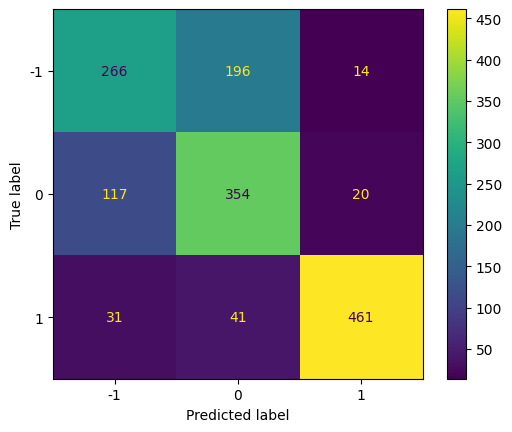

In [25]:
# Evaluate

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(clf_svm, X_test_scaled, y_test)
plt.show()

In [28]:
# Optimize parameters with Cross Validation

from sklearn.model_selection import GridSearchCV

param_grid = [{
    'C': [0.5, 1, 10, 100, 1000],
    'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf'],
}]

optimal_params = GridSearchCV(
    SVC(),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=0
)

optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)
print(optimal_params.best_score_)

{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
0.7275555555555556


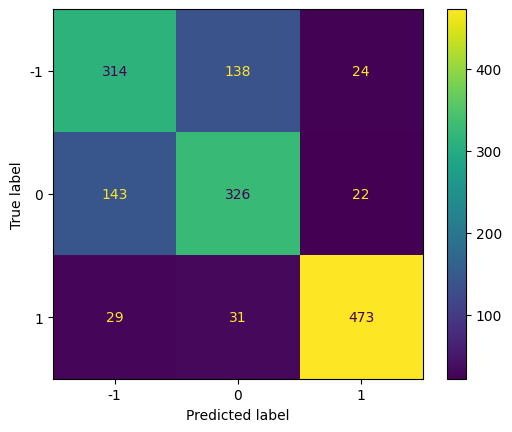

In [30]:
# Optimized Model

clf_svm = SVC(random_state=42, C=1000, gamma=0.01, kernel='rbf')
clf_svm.fit(X_train_scaled, y_train)

ConfusionMatrixDisplay.from_estimator(clf_svm, X_test_scaled, y_test)
plt.show()